In [1]:
%tensorflow_version 2.x
import tensorflow as tf

from tensorflow import keras
import time
import os

print("Tensorflow version " + tf.__version__)
print(tf.config.list_physical_devices("CPU"))
print(tf.config.list_physical_devices("GPU"))


resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://'+os.environ['COLAB_TPU_ADDR'])
#Connect to the TPU handle and initialise it
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

Tensorflow version 2.3.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
INFO:tensorflow:Initializing the TPU system: grpc://10.22.112.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.22.112.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


시간을 찍어요..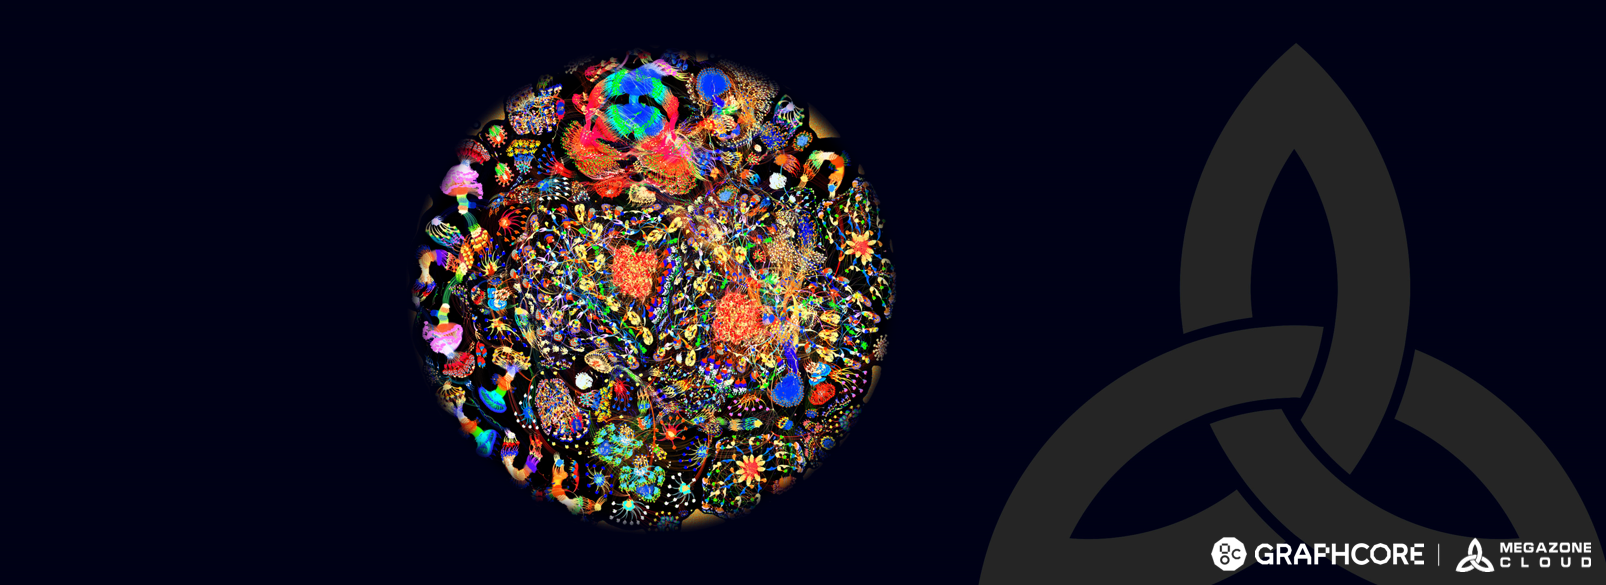

In [2]:
start = time.time() # 시작 시간 저장

In [ ]:
if tf.__version__[0] != '2':
    raise ImportError("TensorFlow 2 is required for this example")

In [ ]:
# The input data and labels.
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, x_test) = (x_train / 255.0, x_test / 255.0)

# Add a channels dimension.
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def create_train_dataset():
    print("==============================Processing Training DataSet==============================\n\n")
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(32, drop_remainder=True)
    train_ds = train_ds.map(lambda d, l: (tf.cast(d, tf.float32), tf.cast(l, tf.float32)))
    return train_ds.repeat()

def create_test_dataset():
    print("==============================Processing Test  DataSet==============================\n\n")
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(10000).batch(32, drop_remainder=True)
    test_ds = test_ds.map(lambda d, l: (tf.cast(d, tf.float32), tf.cast(l, tf.float32)))
    return test_ds.repeat()

In [ ]:
# Create the model using the IPU-specific Sequential class instead of the
# standard tf.keras.Sequential class
def create_model():
    model = tf.keras.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')])
    
    model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                  optimizer = tf.keras.optimizers.Adam(), 
                  experimental_steps_per_execution = 50, 
                  metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
def main():
      # Get the training dataset.
      print("==============================Getting Training DataSet==============================\n\n")
      ds1 = create_train_dataset()
      print("==============================Getting Test DataSet==============================\n\n")
      ds2 = create_test_dataset()

      with strategy.scope():   
        # Create an instance of the model.
        print("==============================Building Model & Compile ==============================\n\n")
        model = create_model()
      #end of with
      
      print("==============================Model Training ==============================\n\n")
      model.fit(ds1, steps_per_epoch=2000, epochs=50)

      print("\n\n==============================Checking the result==============================\n\n")
      loss, accuracy = model.evaluate(ds2, steps=1000)
      print("Validation loss: {}".format(loss))
      print("Validation accuracy: {}%".format(100.0 * accuracy))
      print("\n\n==============================Job Done by TPU !!!==============================")

In [ ]:
if __name__ == '__main__':
    main()

==============================Getting Training DataSet==============================


==============================Processing Training DataSet==============================


==============================Getting Test DataSet==============================


==============================Processing Test  DataSet==============================


==============================Building Model & Compile ==============================


==============================Model Training ==============================


Epoch 1/50
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2099 - sparse_categorical_accuracy: 0.9369
Epoch 2/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0936 - sparse_categorical_accuracy: 0.9707
Epoch 3/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9791
Epoch 4/50
2000/2000 [==============================] - 4s 2ms/step - loss: 0.0518 - sparse_categorical_accuracy: 0.9831
Epo

In [ ]:
print("실행시간 :", time.time() - start,"(초)")  # 현재시각 - 시작시간 = 실행 시간